In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import lightning as L
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.callbacks import BasePredictionWriter
from lightning.pytorch.profilers import PyTorchProfiler

In [30]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):
    df = pd.read_csv(self.data_dir)
    df.index = df['Start_DateTime']
    df = df[['Start_DateTime', 'Energy_Consumption']].sort_index()
    df.dropna(inplace=True)
    df['Start_DateTime'] = pd.to_datetime(df['Start_DateTime'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Start_DateTime', inplace=True)
    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()
    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)
    
    preprocessing = self.scaler
    preprocessing.fit(self.X_train) # should only fit to training data
        
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader
      

In [31]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return self.X.__len__() - (self.seq_len-1)

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [32]:
class LSTM(L.LightningModule):
  def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
    super().__init__()
    self.save_hyperparameters(ignore=['criterion'])
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

In [33]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval):
    super().__init__(write_interval)
    self.output_dir = output_dir

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))
    # torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt")) # for batch indices if needed

In [39]:
params = dict(
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  max_epochs = 50,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 1, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 0, # only work in .py for me
  is_persistent = False, # only work in .py for me
  scaler = MinMaxScaler()
)

In [35]:
model = LSTM(input_size=1, hidden_size=params['hidden_size'], num_layers=params['num_layers'], criterion=params['criterion'], dropout=params['dropout'], learning_rate=params['learning_rate'])
colmod = ColoradoDataModule(data_dir='ColoradoData_Boulder.csv', scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
pred_writer = CustomWriter(output_dir="Models", write_interval="epoch")

Bottleneck finding

In [11]:
trainer_bottleneck = L.Trainer(max_epochs=50, profiler="simple")
trainer_bottleneck.fit(model, colmod)
trainer_bottleneck.test(model, colmod)
trainer_bottleneck.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 116.17it/s, v_num=1, train_loss_step=0.430, val_loss_step=5.710, val_loss_epoch=40.90, train_loss_epoch=53.60]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 114.77it/s, v_num=1, train_loss_step=0.430, val_loss_step=5.710, val_loss_epoch=40.90, train_loss_epoch=53.60]


FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  147535         	|

Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 122.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    30.120895385742188     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  147888         	

Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 139.41it/s]


PREDICT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  148241       

CPU Usage

In [38]:
trainer_cpu = L.Trainer(profiler=PyTorchProfiler())
trainer_cpu.fit(model, colmod)
trainer_cpu.test(model, colmod)
trainer_cpu.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


STAGE:2025-03-20 12:48:45 61077:35546991 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 0:   6%|▌         | 4/72 [00:00<00:02, 25.88it/s, v_num=0, train_loss_step=198.0]

STAGE:2025-03-20 12:48:46 61077:35546991 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-20 12:48:46 61077:35546991 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
[W collection.cpp:602] Warning: Optimizer.step#Adam.step (function operator())
[W collection.cpp:602] Warning: [pl][profile][LightningModule]LSTM.optimizer_step (function operator())


Epoch 1:   1%|▏         | 1/72 [00:00<00:00, 118.66it/s, v_num=0, train_loss_step=51.60, val_loss_step=6.030, val_loss_epoch=50.10, train_loss_epoch=84.50]

STAGE:2025-03-20 12:48:47 61077:35546991 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-03-20 12:48:47 61077:35546991 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-20 12:48:47 61077:35546991 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 999: 100%|██████████| 72/72 [00:00<00:00, 106.71it/s, v_num=0, train_loss_step=0.105, val_loss_step=8.450, val_loss_epoch=37.70, train_loss_epoch=0.856]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 72/72 [00:00<00:00, 105.61it/s, v_num=0, train_loss_step=0.105, val_loss_step=8.450, val_loss_epoch=37.70, train_loss_epoch=0.856]


FIT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*        27.58%       3.785ms       100.00%      13.724ms       6.862ms             2  
[pl][profile][Strategy]SingleDeviceStrategy.validati...        12.10%       1.660ms        35.17%       4.827ms       2.413ms             2  
[pl][profile][Callback]TQDMProgressBar.on_validation...        26.94%       3.697ms        26.94%       3.697ms       1.849ms             2  
            [pl][module]torch.nn.modules.rnn.LSTM: lstm         1.63%     224.000us        19.32%    

Testing DataLoader 0:  57%|█████▋    | 13/23 [00:00<00:00, 134.17it/s]

STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 80.99it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     34.29313278198242     │
└───────────────────────────┴───────────────────────────┘

TEST Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*        26.37%       4.970ms       100.00%      18.848ms       6.283ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.test_ste...        16.29%       3.070ms        46.39%       8.744ms       2.915ms             3  
            [pl][module]torch.nn.modules.rnn.LSTM: lstm         2.41%     455.000us        26.88%       5.066ms       1.689ms             3  
                                             aten::lstm         0.47%      88.000us        24.25%   

Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 250.70it/s]


STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-03-20 13:00:48 61077:35546991 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
PREDICT Profiler Report
Profile stats for: records
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*        25.91%       3.109ms       100.00%      12.000ms       4.000ms             3  
[pl][profile][Strategy]SingleDeviceStrategy.predict_...         

Performance Evaluation (Measures accelerator usage)

In [12]:
trainer_eval = L.Trainer(max_epochs=50, callbacks=[DeviceStatsMonitor()])
trainer_eval.fit(model, colmod)
trainer_eval.test(model, colmod)
trainer_eval.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 97.35it/s, v_num=2, train_loss_step=0.00275, val_loss_step=6.860, val_loss_epoch=26.20, train_loss_epoch=33.00] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 96.49it/s, v_num=2, train_loss_step=0.00275, val_loss_step=6.860, val_loss_epoch=26.20, train_loss_epoch=33.00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 210.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    20.643211364746094     │
└───────────────────────────┴───────────────────────────┘

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 350.47it/s]


Fast Development run (runs n batches of training, validation and test to check for bugs)

In [13]:
trainer_dev = L.Trainer(max_epochs=params['max_epochs'], default_root_dir='Models', callbacks=[EarlyStopping(monitor="val_loss", mode="min")], fast_dev_run=10)
trainer_dev.fit(model, colmod)
trainer_dev.test(model, colmod)
trainer_dev.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 10 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader`

Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 73.11it/s, train_loss_step=34.50, val_loss_step=24.70, val_loss_epoch=26.50, train_loss_epoch=19.10]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 71.87it/s, train_loss_step=34.50, val_loss_step=24.70, val_loss_epoch=26.50, train_loss_epoch=19.10]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     29.19832420349121     │
└───────────────────────────┴───────────────────────────┘

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 227.83it/s]


Find largest batch size fitting into memory, often yielding better estimations of gradients but can result in longer runtimes

In [17]:
trainer_tun = L.Trainer(max_epochs=params['max_epochs'], default_root_dir='Models', callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
tuner = Tuner(trainer_tun)

tuner.scale_batch_size(model, colmod, mode="power")
# tuner.scale_batch_size(model, colmod, mode="binsearch")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
The batch size 1024 is greater or equal than the length of your dataset.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' do

1024

Find Learning Rate Tuning

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing t

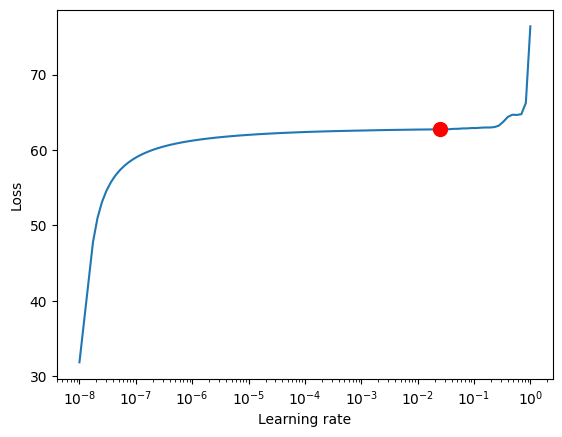

In [23]:
trainer_LRtun = L.Trainer(max_epochs=params['max_epochs'], default_root_dir='Models', callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
tuner2 = Tuner(trainer_LRtun)

lr_finder = tuner2.lr_find(model, colmod)
# print(lr_finder.results)

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()

## Runs

Standard Run

In [15]:
trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="val_loss", mode="min"), pred_writer], default_root_dir='Models')
trainer.fit(model, colmod)
trainer.test(model, colmod)
trainer.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 72/72 [00:00<00:00, 114.45it/s, v_num=27, train_loss_step=0.000165, val_loss_step=7.440, val_loss_epoch=26.10, train_loss_epoch=30.80]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 262.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    20.516950607299805     │
└───────────────────────────┴───────────────────────────┘

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 380.15it/s]


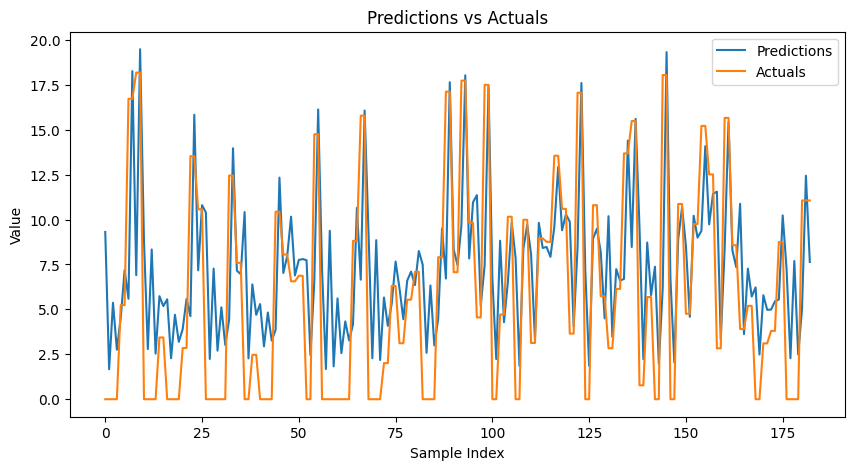

In [16]:
predictions = torch.load('Models/predictions_0.pt')

actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

# Flatten the predictions and actuals
predictions_flat = [item.item() for sublist in predictions for item in sublist]
actuals_flat = [item for sublist in actuals for item in sublist]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(predictions_flat, label='Predictions')
plt.plot(actuals_flat, label='Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()

In [17]:
%reload_ext tensorboard
%tensorboard --logdir=Models/lightning_logs/

Reusing TensorBoard on port 6007 (pid 26215), started 23:26:11 ago. (Use '!kill 26215' to kill it.)